# Notebook 22: Chapter 6 Figures

This notebook performs a segmentation workflow adapted from NB 11.
The F50 sand experiment F63 is used to generate figures to be used in Chapter
6 of Gus's thesis.

# Import packages

In [2]:
# Standard library imports
from pathlib import Path
# Third-party imports
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import ndimage as ndi
from scipy import signal
from skimage import color, measure
# Local module imports
from segmentflow import segment, view
# Enable autoreload packages for changes made to local modules
%load_ext autoreload
%autoreload 2

## Load 3D data

Passing `slice_crop`, `row_crop`, and `col_crop` to only load part of the dataset

In [3]:
ums_per_pixel = 13.84

Loading images...
--> Images loaded as 3D array:  (150, 150, 150)
Plotting images: [  0  74 149]


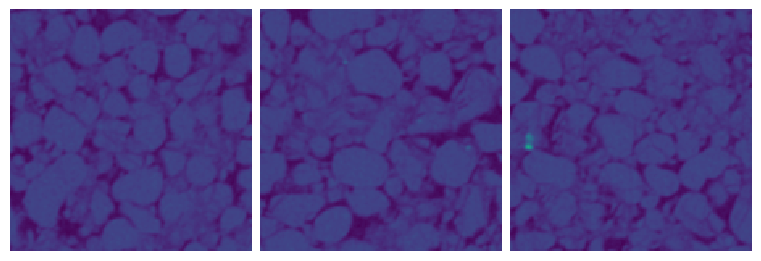

In [4]:
# Load images as 3D array from a directory containing images
imgs = segment.load_images(
    Path('../data/F63tiff/'),
    slice_crop=[400, 550],
    row_crop=[400, 550],
    col_crop=[400, 550],
    convert_to_float=True,
    file_suffix='tiff'
)
slices = np.linspace(0, 149, 3).astype(int)
fig, axes = view.plot_slices(imgs, slices=slices)

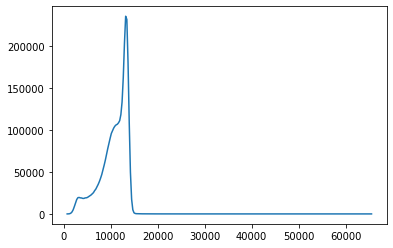

In [5]:
hist, bin_edges = np.histogram(imgs, bins=256)
fig, ax = plt.subplots()
ax.plot(bin_edges[1:], hist)
plt.show()

## Preprocess data

Preprocessing images...
--> Applying median filter...
--> Rescaling intensities to percentile range [0, 99.9]...
--> Preprocessing complete
Plotting images: [  0  74 149]


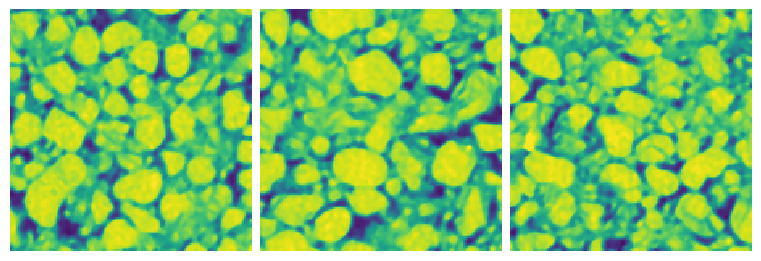

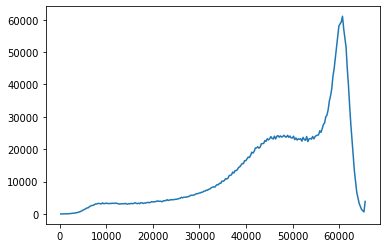

In [6]:
imgs_pre = segment.preprocess(
    imgs, median_filter=True, rescale_intensity_range=[0, 99.9]
)
fig, axes = view.plot_slices(imgs_pre, slices=slices)
hist, bin_edges = np.histogram(imgs_pre, bins=256)
fig, ax = plt.subplots()
ax.plot(bin_edges[1:], hist)
plt.show()

--> 3 peak(s) found: [11796.300000000001, 47840.55, 59636.85]
--> 2 min(s) found: [12451.65, 51117.3]


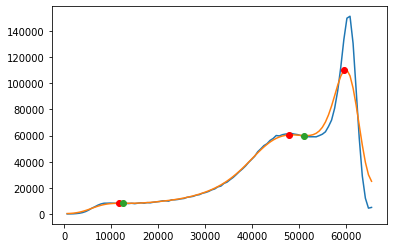

In [7]:
fig, ax = plt.subplots()
nbins = 100
# Calculate histogram
hist, bins = np.histogram(imgs_pre, bins=nbins)
ax.plot(bins[1:], hist)
# Smooth histogram with Gaussian filter
hist_smooth = ndi.gaussian_filter(hist, 3)
ax.plot(bins[1:], hist_smooth, c='C1')
# Find local maxima in smoothed histogram
peak_inds, peak_props = signal.find_peaks(hist_smooth)
peaks = [bins[i] for i in peak_inds]
print(f'--> {len(peaks)} peak(s) found: {peaks}')
for i, val in zip(peak_inds, peaks):
    ax.scatter(val, hist_smooth[i], color='red', zorder=2)
# Find minima between each neighboring pair of local maxima
min_inds = []
for i in range(1, len(peak_inds)):
    min_sub_i = np.argmin(hist_smooth[peak_inds[i - 1] : peak_inds[i]])
    min_inds.append(min_sub_i + peak_inds[i - 1])
mins = [bins[i] for i in min_inds]
print(f'--> {len(mins)} min(s) found: {mins}')
for i, val in zip(min_inds, mins):
    ax.scatter(val, hist_smooth[i], color='C2', zorder=2)
plt.show()

n_vox_binder=1669941
n_vox_grains=1616107
n_vox_nonvoid=3286048
Plotting images: [  0  74 149]


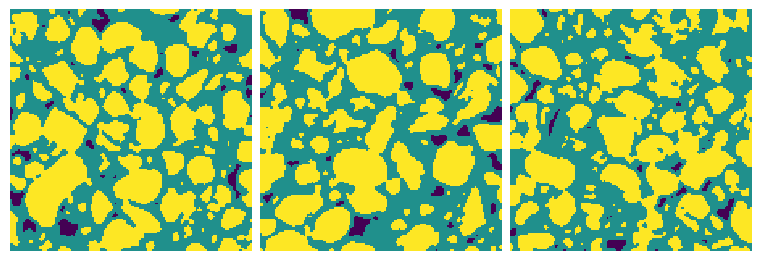

In [8]:
imgs_semantic = segment.isolate_classes(imgs_pre, mins)
n_vox_binder = (imgs_semantic == 1).sum()
print(f'{n_vox_binder=}')
n_vox_grains = (imgs_semantic == 2).sum()
print(f'{n_vox_grains=}')
n_vox_nonvoid = (imgs_semantic > 0).sum()
print(f'{n_vox_nonvoid=}')
fig, axes = view.plot_slices(imgs_semantic, slices=slices)

## Segment Data

### Single segmentation

Segmenting images...
--> Segmentation complete. 520 particle(s) segmented.


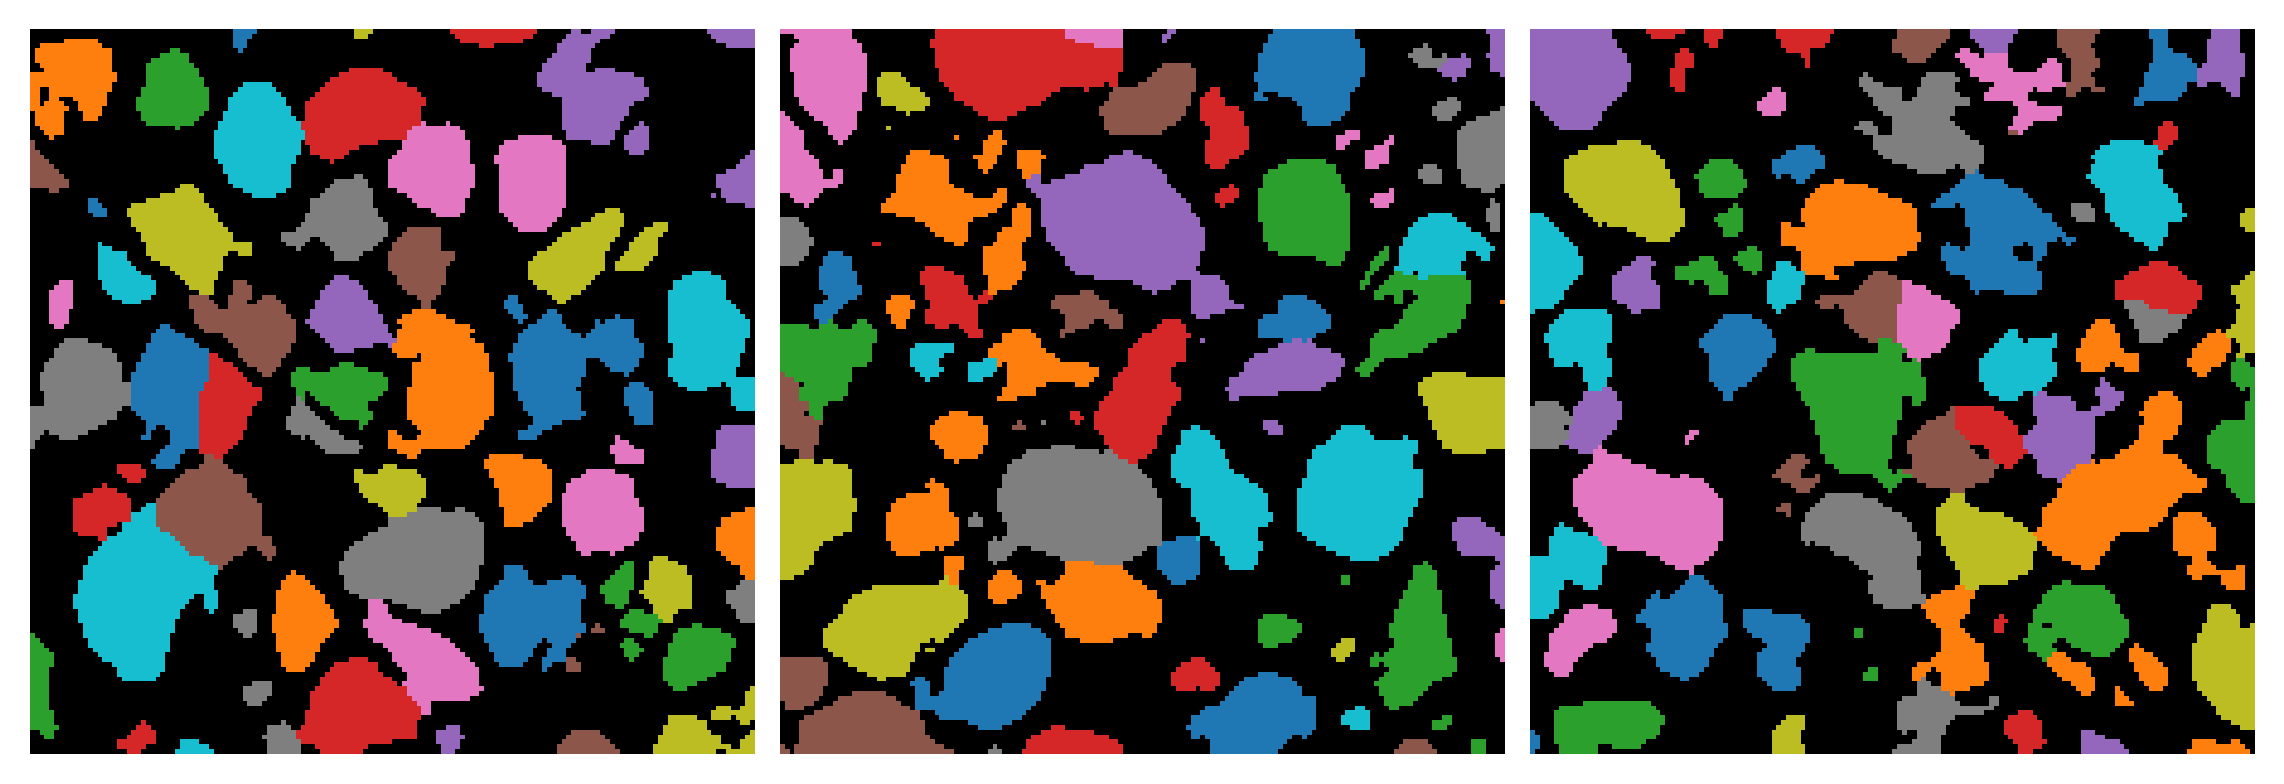

In [26]:
imgs_labeled = segment.watershed_segment(
    imgs_semantic == 2,
    min_peak_distance=7,
    return_dict=False
)
colors = view.get_colors(10, cmap=mpl.cm.tab10)
labeled_color = [
    color.label2rgb(imgs_labeled[i, ...], bg_label=0, colors=colors)
    for i in slices
]
fig, axes = view.plot_images(labeled_color, dpi=300)

### Compare effect of `min_peak_distance` on size

min_peak_distance = 8
Segmenting images...
--> Segmentation complete. 421 particle(s) segmented.


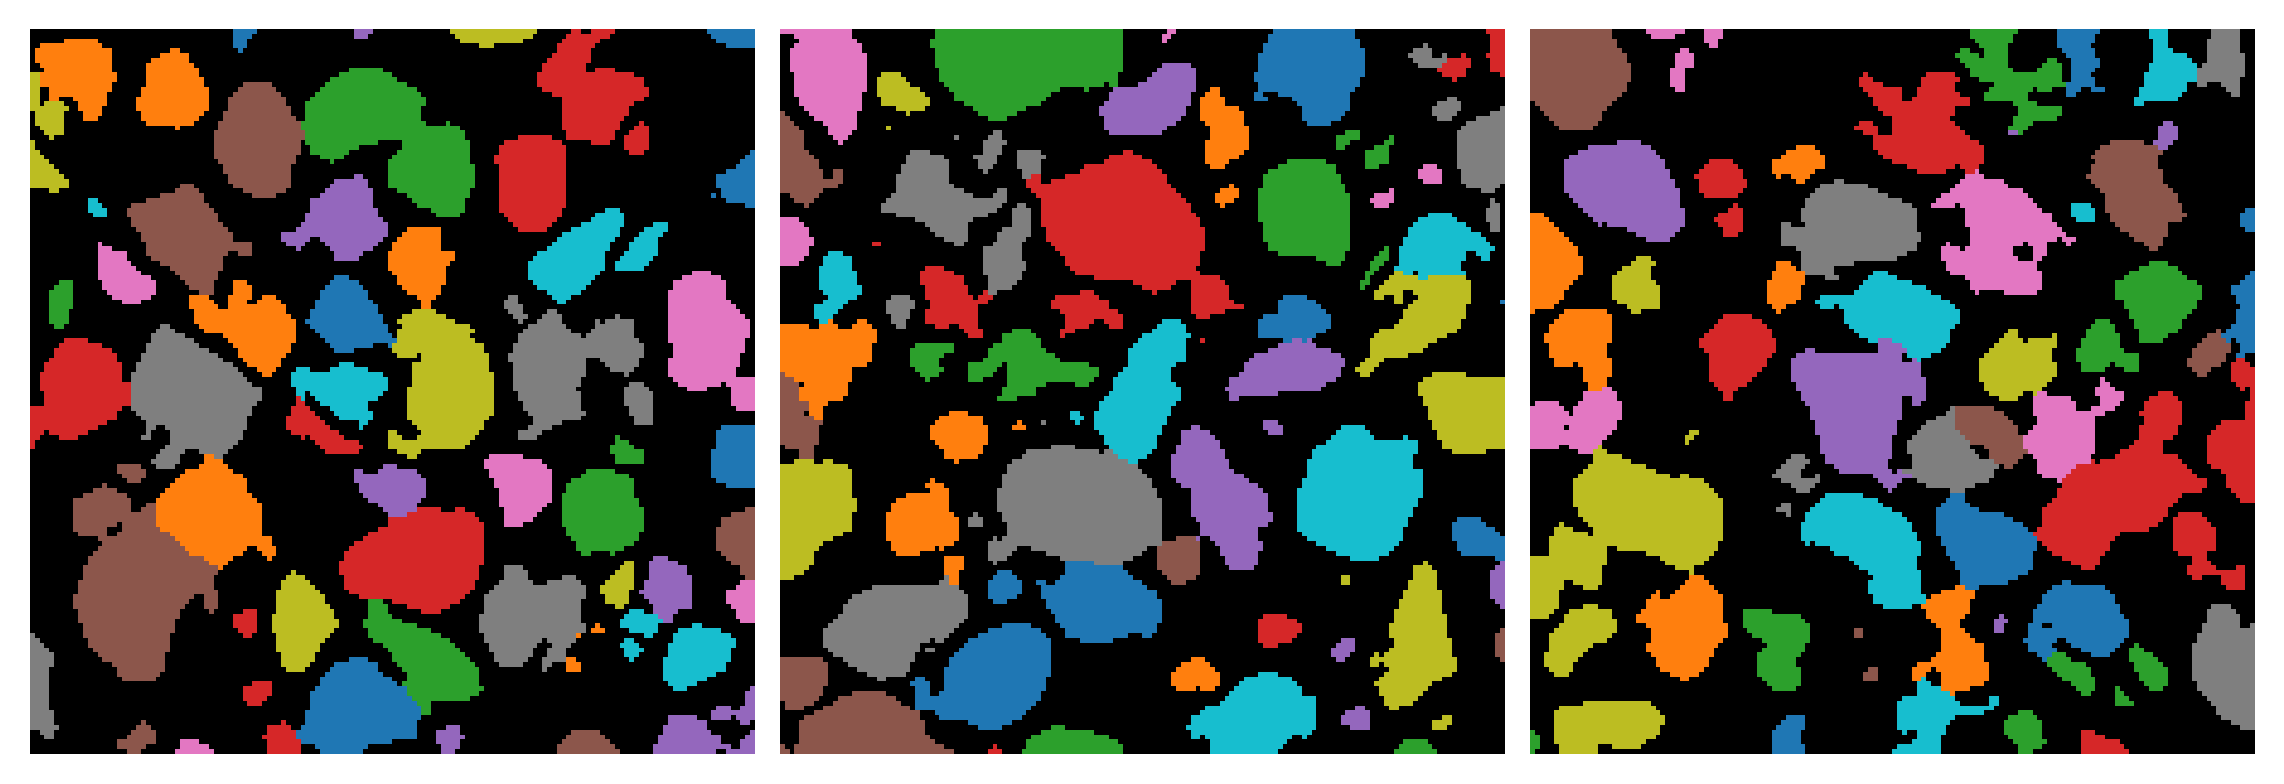

min_peak_distance = 7
Segmenting images...
--> Segmentation complete. 520 particle(s) segmented.


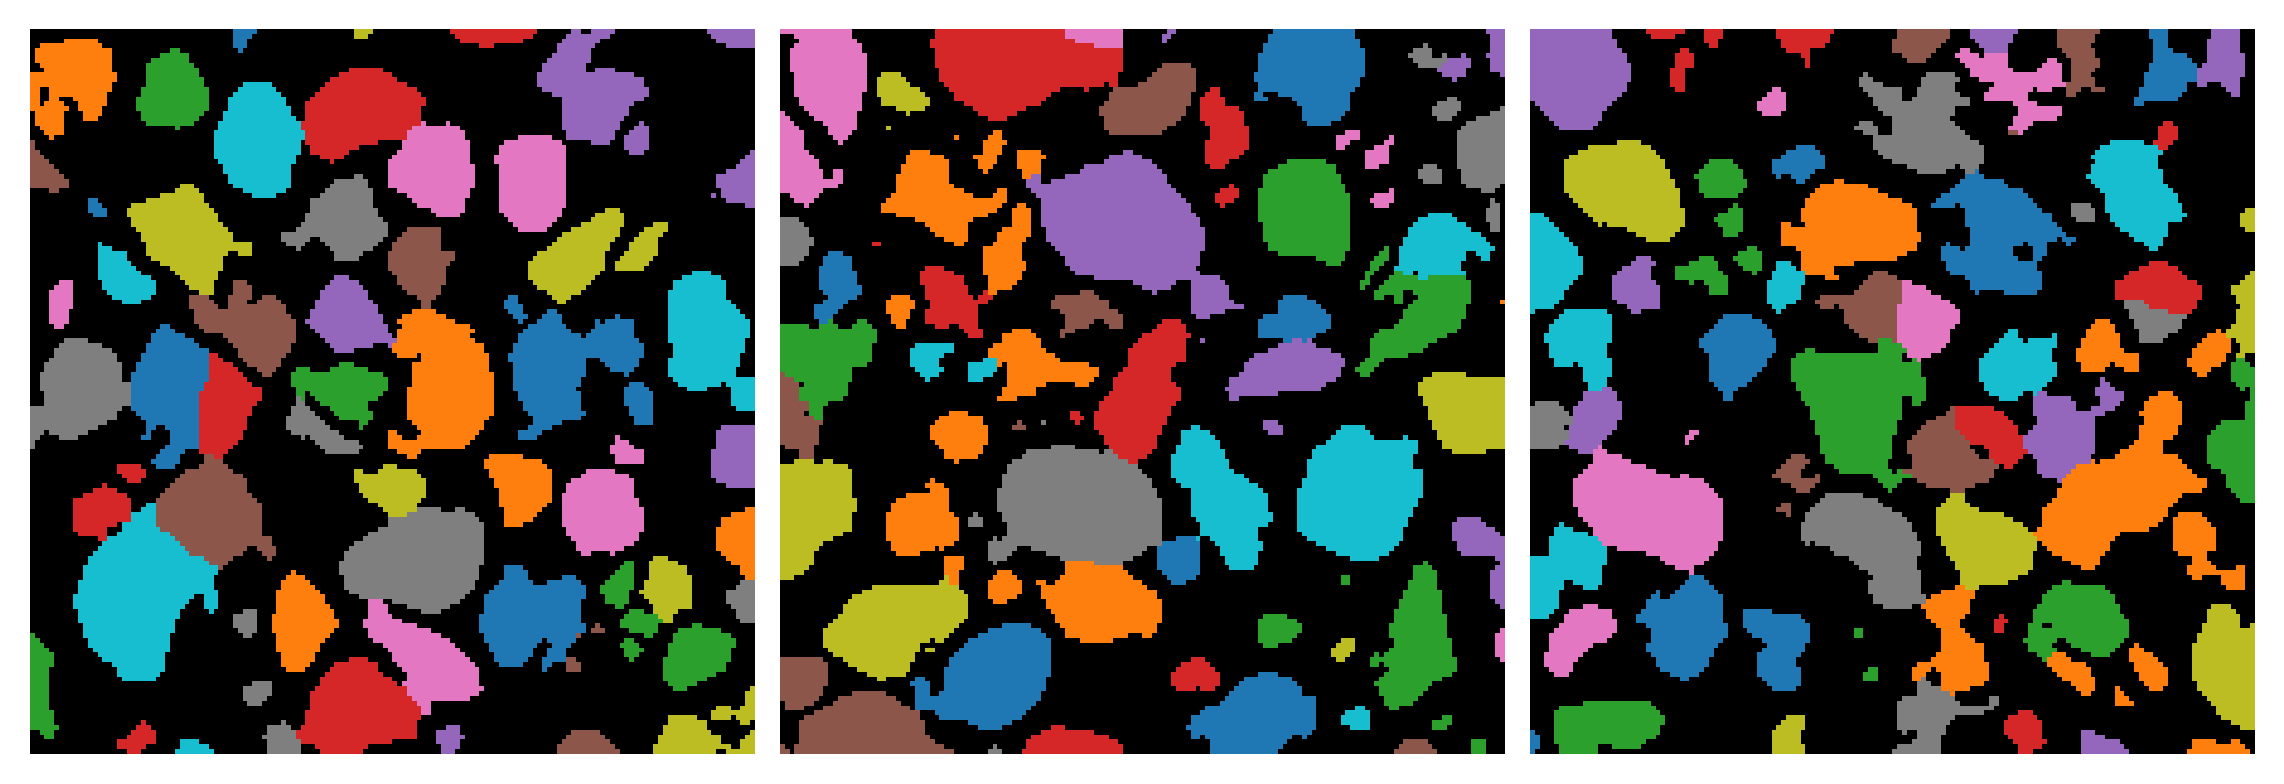

min_peak_distance = 6
Segmenting images...
--> Segmentation complete. 649 particle(s) segmented.


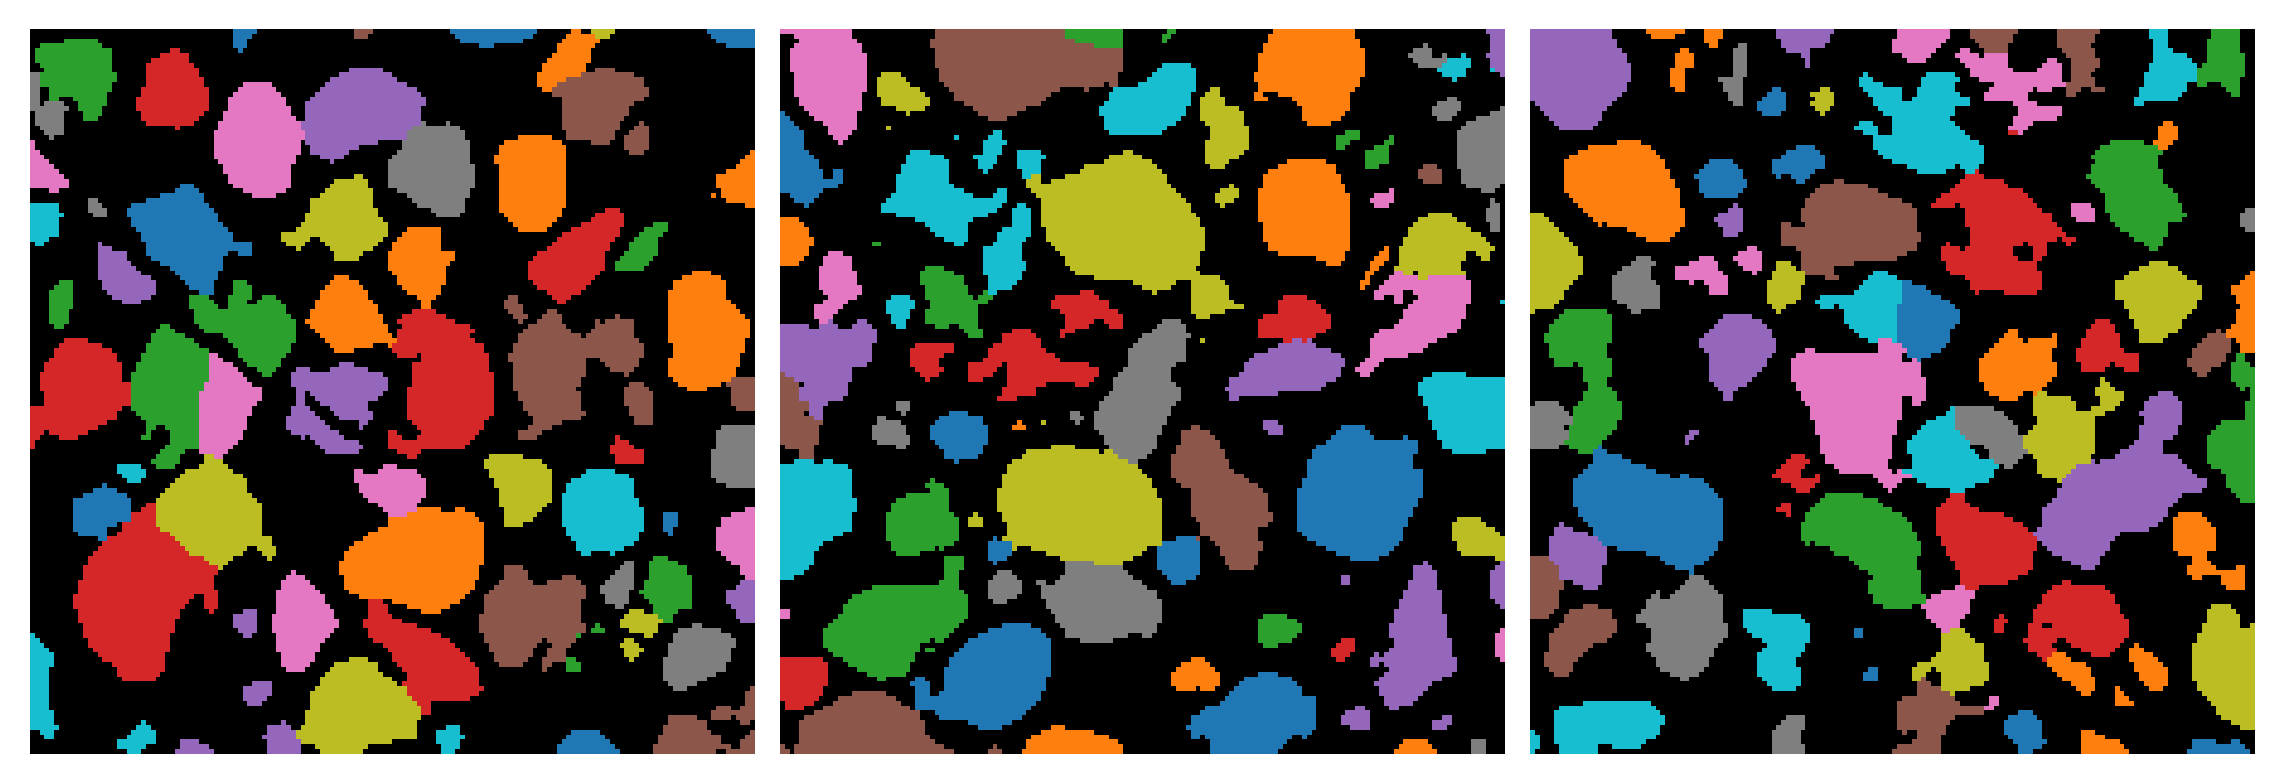

min_peak_distance = 5
Segmenting images...
--> Segmentation complete. 878 particle(s) segmented.


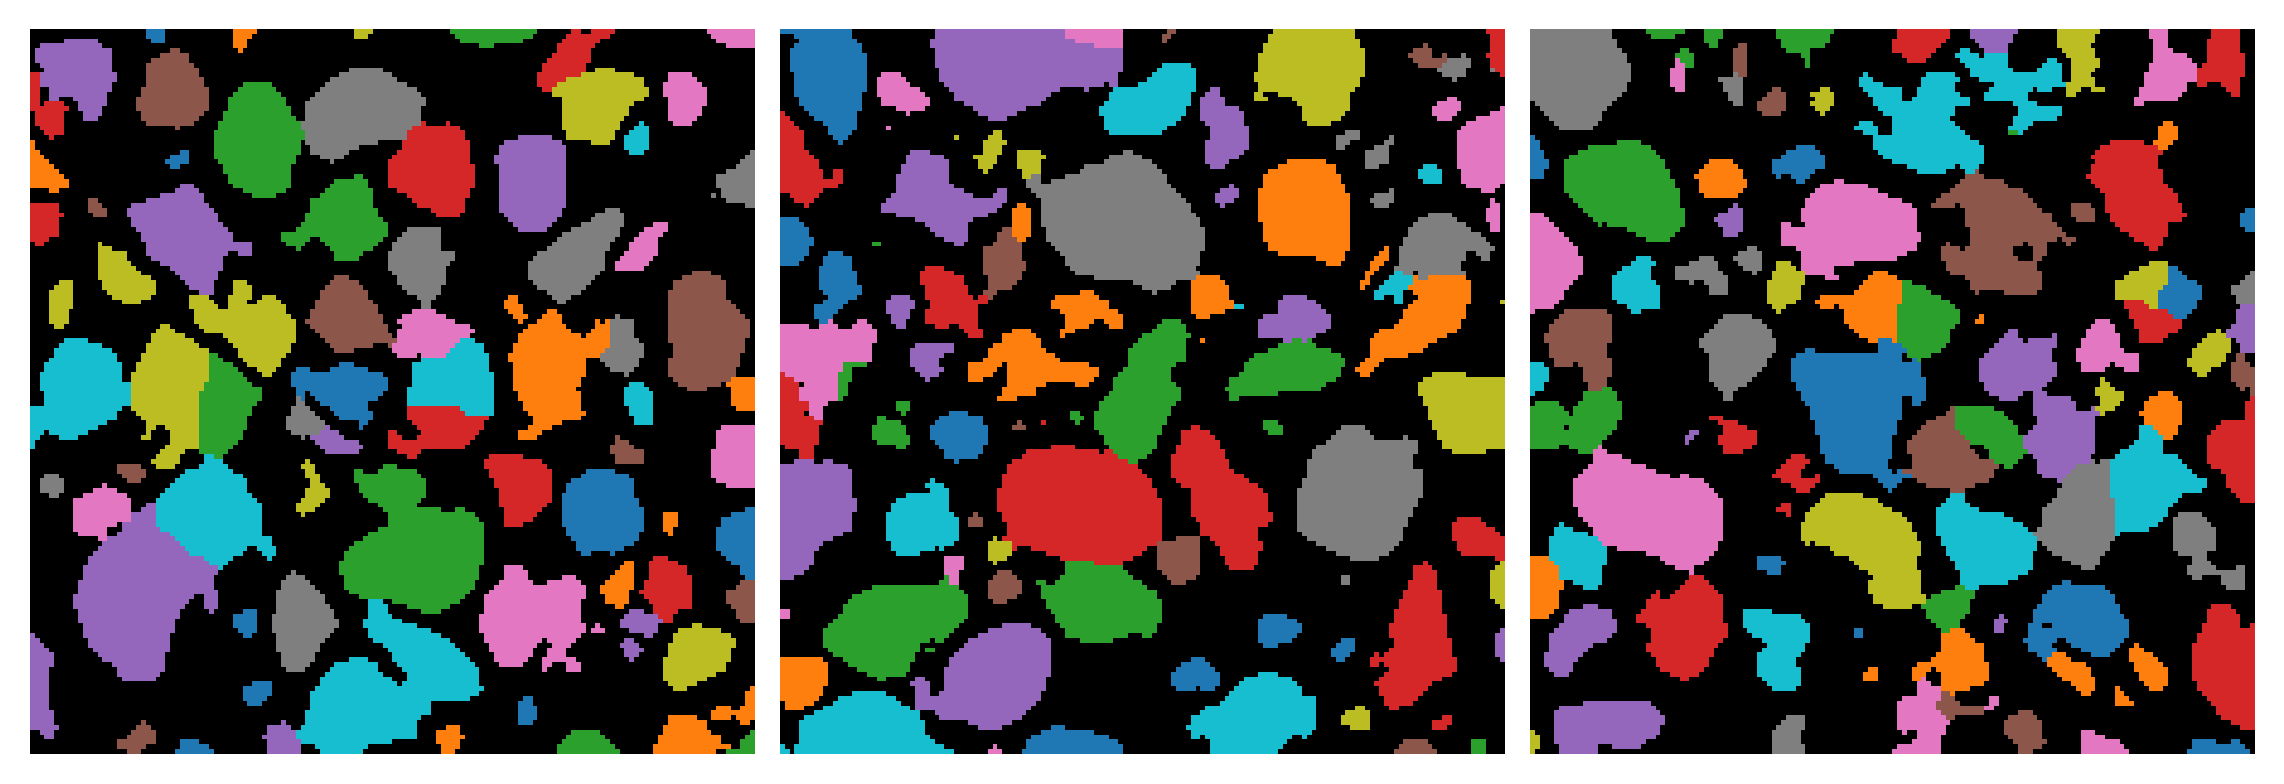

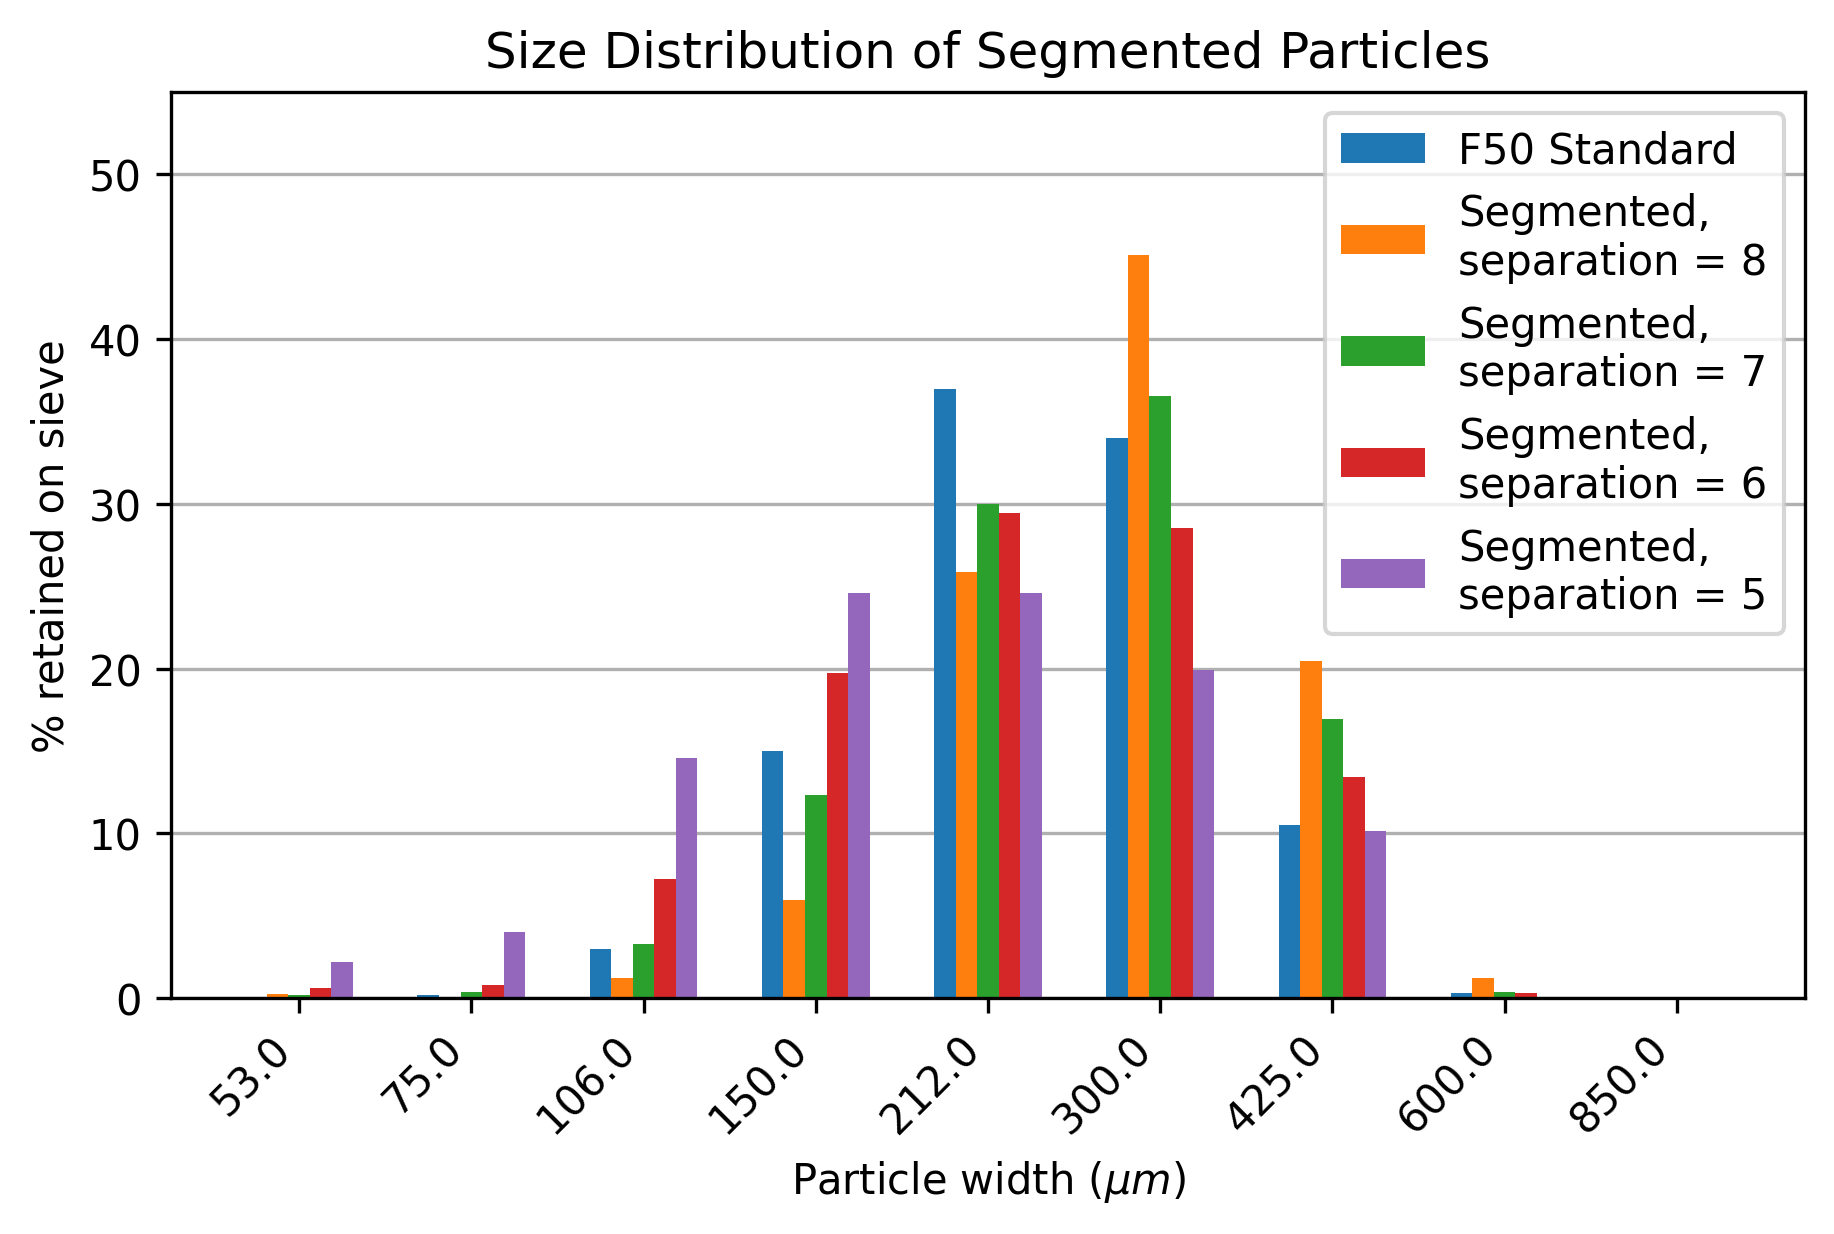

In [148]:
# Collect sieve data
sieve_df = pd.read_csv(
    Path('../data/F50-sieve.csv'), index_col=0).sort_values('um')
ums_area = sieve_df.um.to_numpy()
r = ums_area / 2
ums_vol = 4/3 * np.pi * r**3
ums_vol_bins = np.insert(ums_vol, 0, 0)
f50_pct = sieve_df['pct-retained'].to_numpy()
min_peak_dist_range = np.arange(5, 9)[::-1]
for dist_i in min_peak_dist_range:
    print('min_peak_distance =', dist_i)
    # Segment data
    imgs_labeled = segment.watershed_segment(
        imgs_semantic == 2,
        min_peak_distance=dist_i,
        return_dict=False
    )
    colors = view.get_colors(10, cmap=mpl.cm.tab10)
    labeled_color = [
        color.label2rgb(imgs_labeled[i, ...], bg_label=0, colors=colors)
        for i in slices
    ]
    fig, axes = view.plot_images(labeled_color, dpi=300)
    # Format segmented data
    labels_df = pd.DataFrame(measure.regionprops_table(
        imgs_labeled, properties=['label', 'area', 'bbox']))
    labels_df = labels_df.rename(columns={'area' : 'volume'})
    seg_vols = labels_df.volume.to_numpy() * ums_per_pixel**3
    seg_hist, bins = np.histogram(seg_vols, bins=ums_vol_bins)
    seg_pct = 100 * seg_hist / labels_df.shape[0]
    sieve_df[f'pct-retained-seg-{dist_i}'] = seg_pct
    plt.show()
# Plot histogram
fig, ax = plt.subplots(facecolor='white', constrained_layout=True, dpi=300)
x_pos = np.arange(f50_pct.shape[0])  # the label locations
width = 0.5 / min_peak_dist_range.shape[0]  # the width of the bars
rects_f50 = ax.bar(
    x_pos - width * min_peak_dist_range.shape[0] / 2,
    np.around(f50_pct, 2), width, zorder=2,
    label='F50 Standard')
for i, dist_i in enumerate(min_peak_dist_range):
    seg_i_pct = sieve_df[f'pct-retained-seg-{dist_i}'].to_numpy()
    rects_seg = ax.bar(
        x_pos + (width * (i + 1 - min_peak_dist_range.shape[0] / 2)),
        np.around(seg_i_pct, 2), width, zorder=2,
        label=f'Segmented,\nseparation = {dist_i}')
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_title('Size Distribution of Segmented Particles')
ax.set_ylabel(r'% retained on sieve')
ax.set_ylim([0, 55])
ax.grid(True, axis='y', zorder=0)
ax.set_xticks(x_pos, ums_area, rotation=45, ha='right')
ax.set_xlabel('Particle width ($\mu m$)')
ax.legend()
# ax.bar_label(rects_f50, padding=3, rotation=90)
# ax.bar_label(rects_seg, padding=3, rotation=90)
plt.show()

### Alternative segmentated particle size distributions

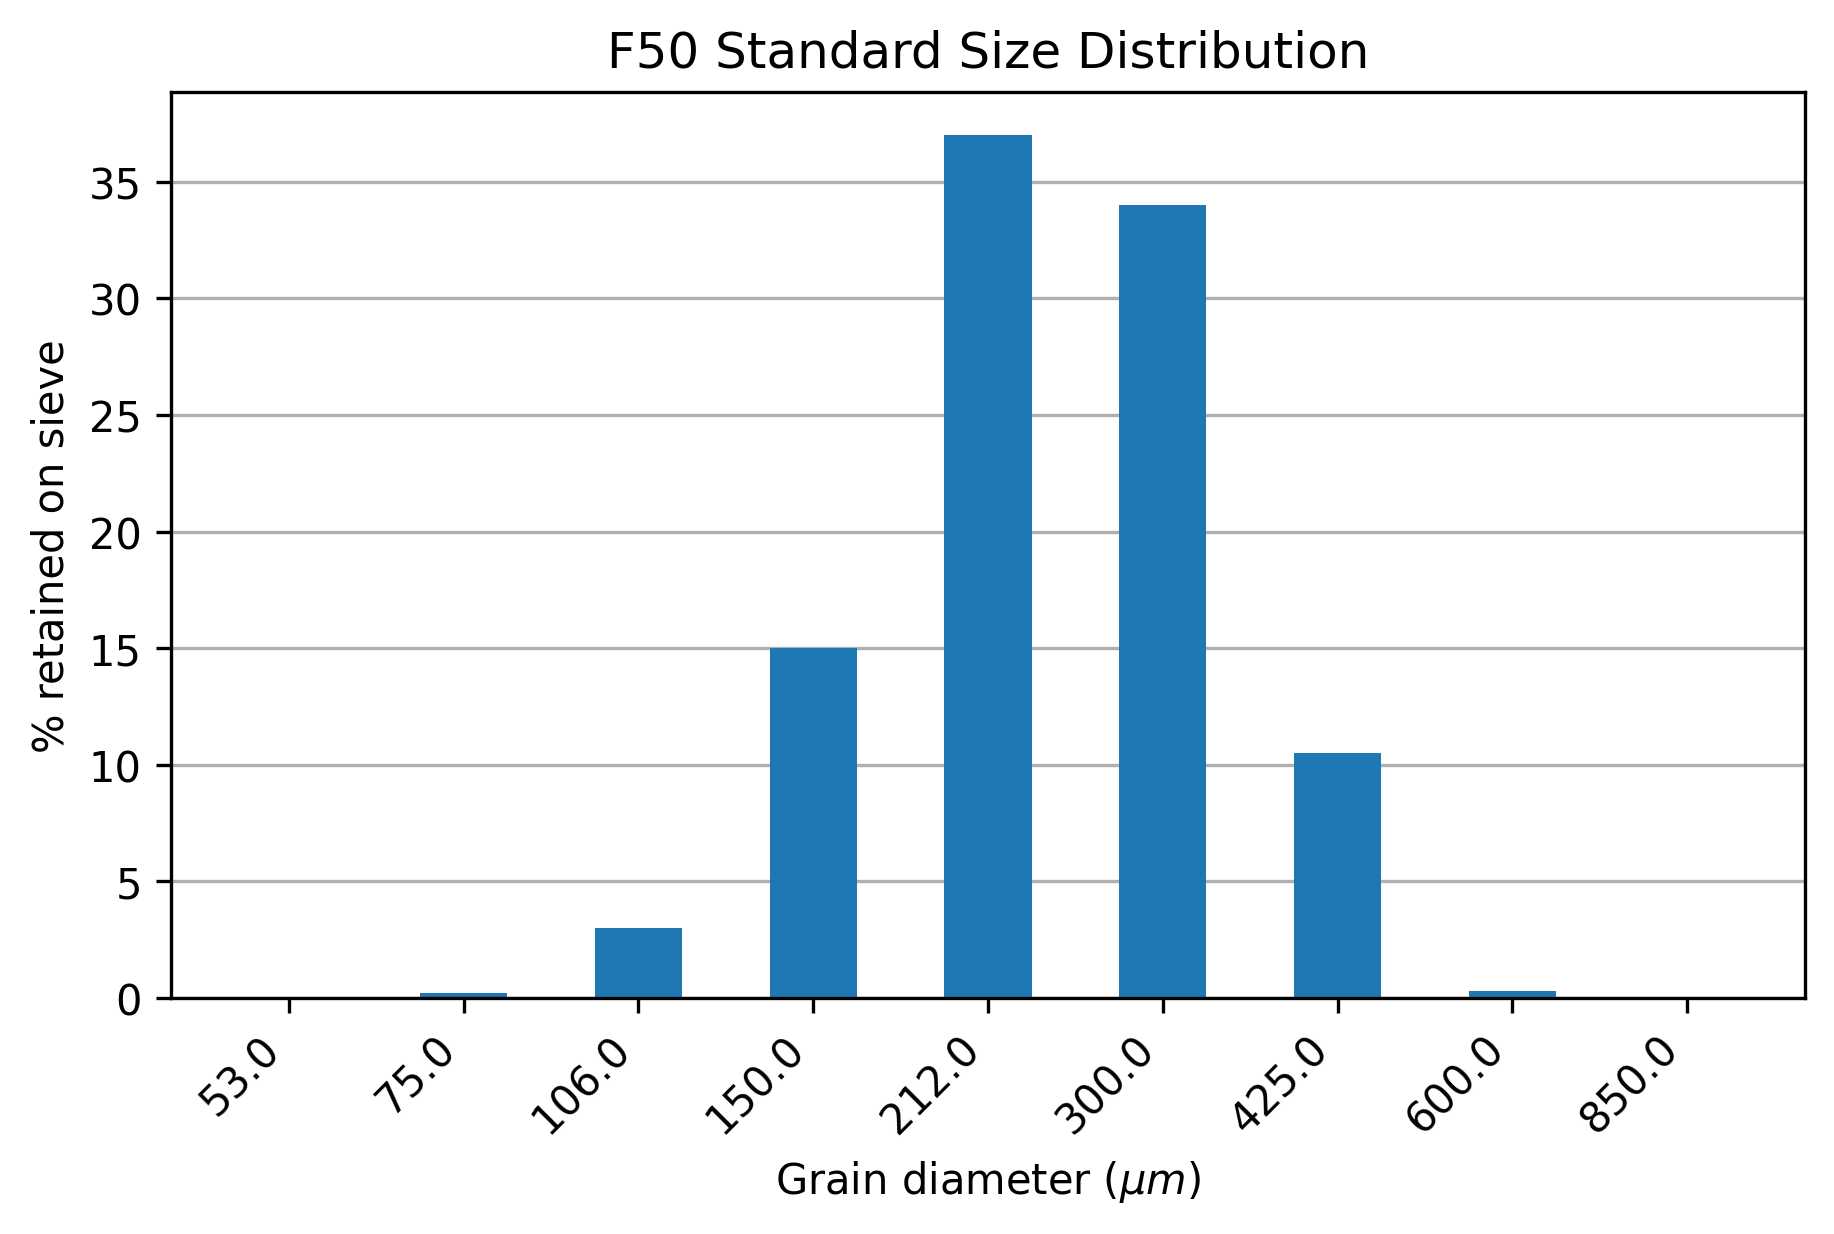

In [141]:
# Plot histogram
fig, ax = plt.subplots(facecolor='white', constrained_layout=True, dpi=300)
x_pos = np.arange(f50_pct.shape[0])  # the label locations
width = 0.5  # the width of the bars
rects_f50 = ax.bar(
    x_pos, np.around(f50_pct, 2), width, zorder=2,
    label='F50 Standard')
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_title('F50 Standard Size Distribution')
ax.set_ylabel(r'% retained on sieve')
# ax.set_ylim([0, 55])
ax.grid(True, axis='y', zorder=0)
ax.set_xticks(x_pos, ums_area, rotation=45, ha='right')
ax.set_xlabel('Grain diameter ($\mu m$)')
# ax.bar_label(rects_f50, padding=3, rotation=90)
plt.show()

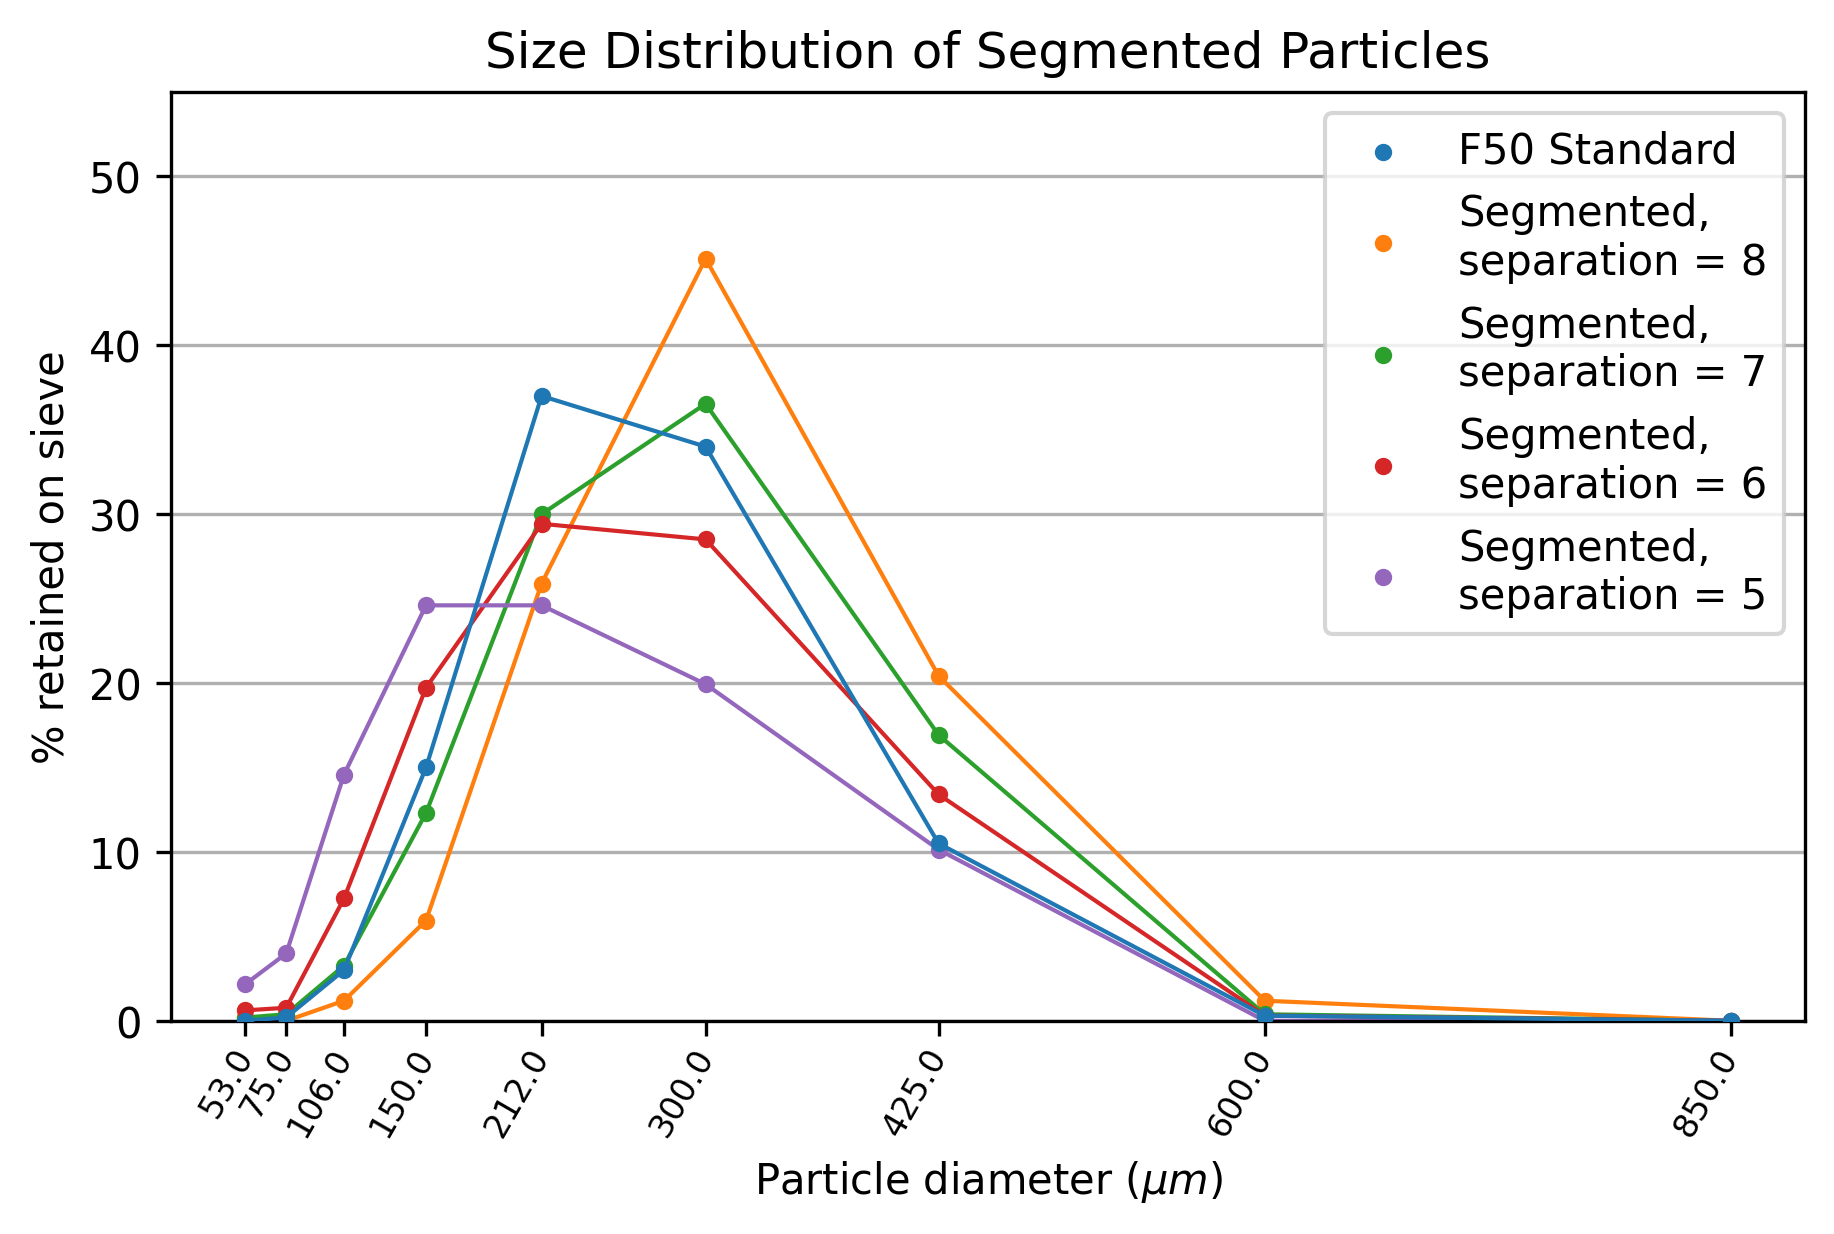

In [145]:
# Plot histogram
fig, ax = plt.subplots(facecolor='white', constrained_layout=True, dpi=300)
x_pos = np.arange(f50_pct.shape[0])  # the label locations
width = 0.5 / min_peak_dist_range.shape[0]  # the width of the bars
ax.scatter(ums_area, f50_pct, s=10, zorder=3, label='F50 Standard')
ax.plot(ums_area, f50_pct, linewidth=1, zorder=3)
for i, dist_i in enumerate(min_peak_dist_range):
    seg_i_pct = sieve_df[f'pct-retained-seg-{dist_i}'].to_numpy()
    ax.scatter(
        ums_area, seg_i_pct, s=10, zorder=2,
        label=f'Segmented,\nseparation = {dist_i}')
    ax.plot(ums_area, seg_i_pct, linewidth=1, zorder=2)
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_title('Size Distribution of Segmented Particles')
ax.set_ylabel(r'% retained on sieve')
ax.set_ylim([0, 55])
ax.grid(True, axis='y', zorder=0)
ax.set_xlabel('Particle diameter ($\mu m$)')
ax.set_xticks(ums_area)
ax.set_xticklabels(
    ums_area, size=8, ha='right', va='center', rotation=60, rotation_mode='anchor')
ax.legend()
plt.show()

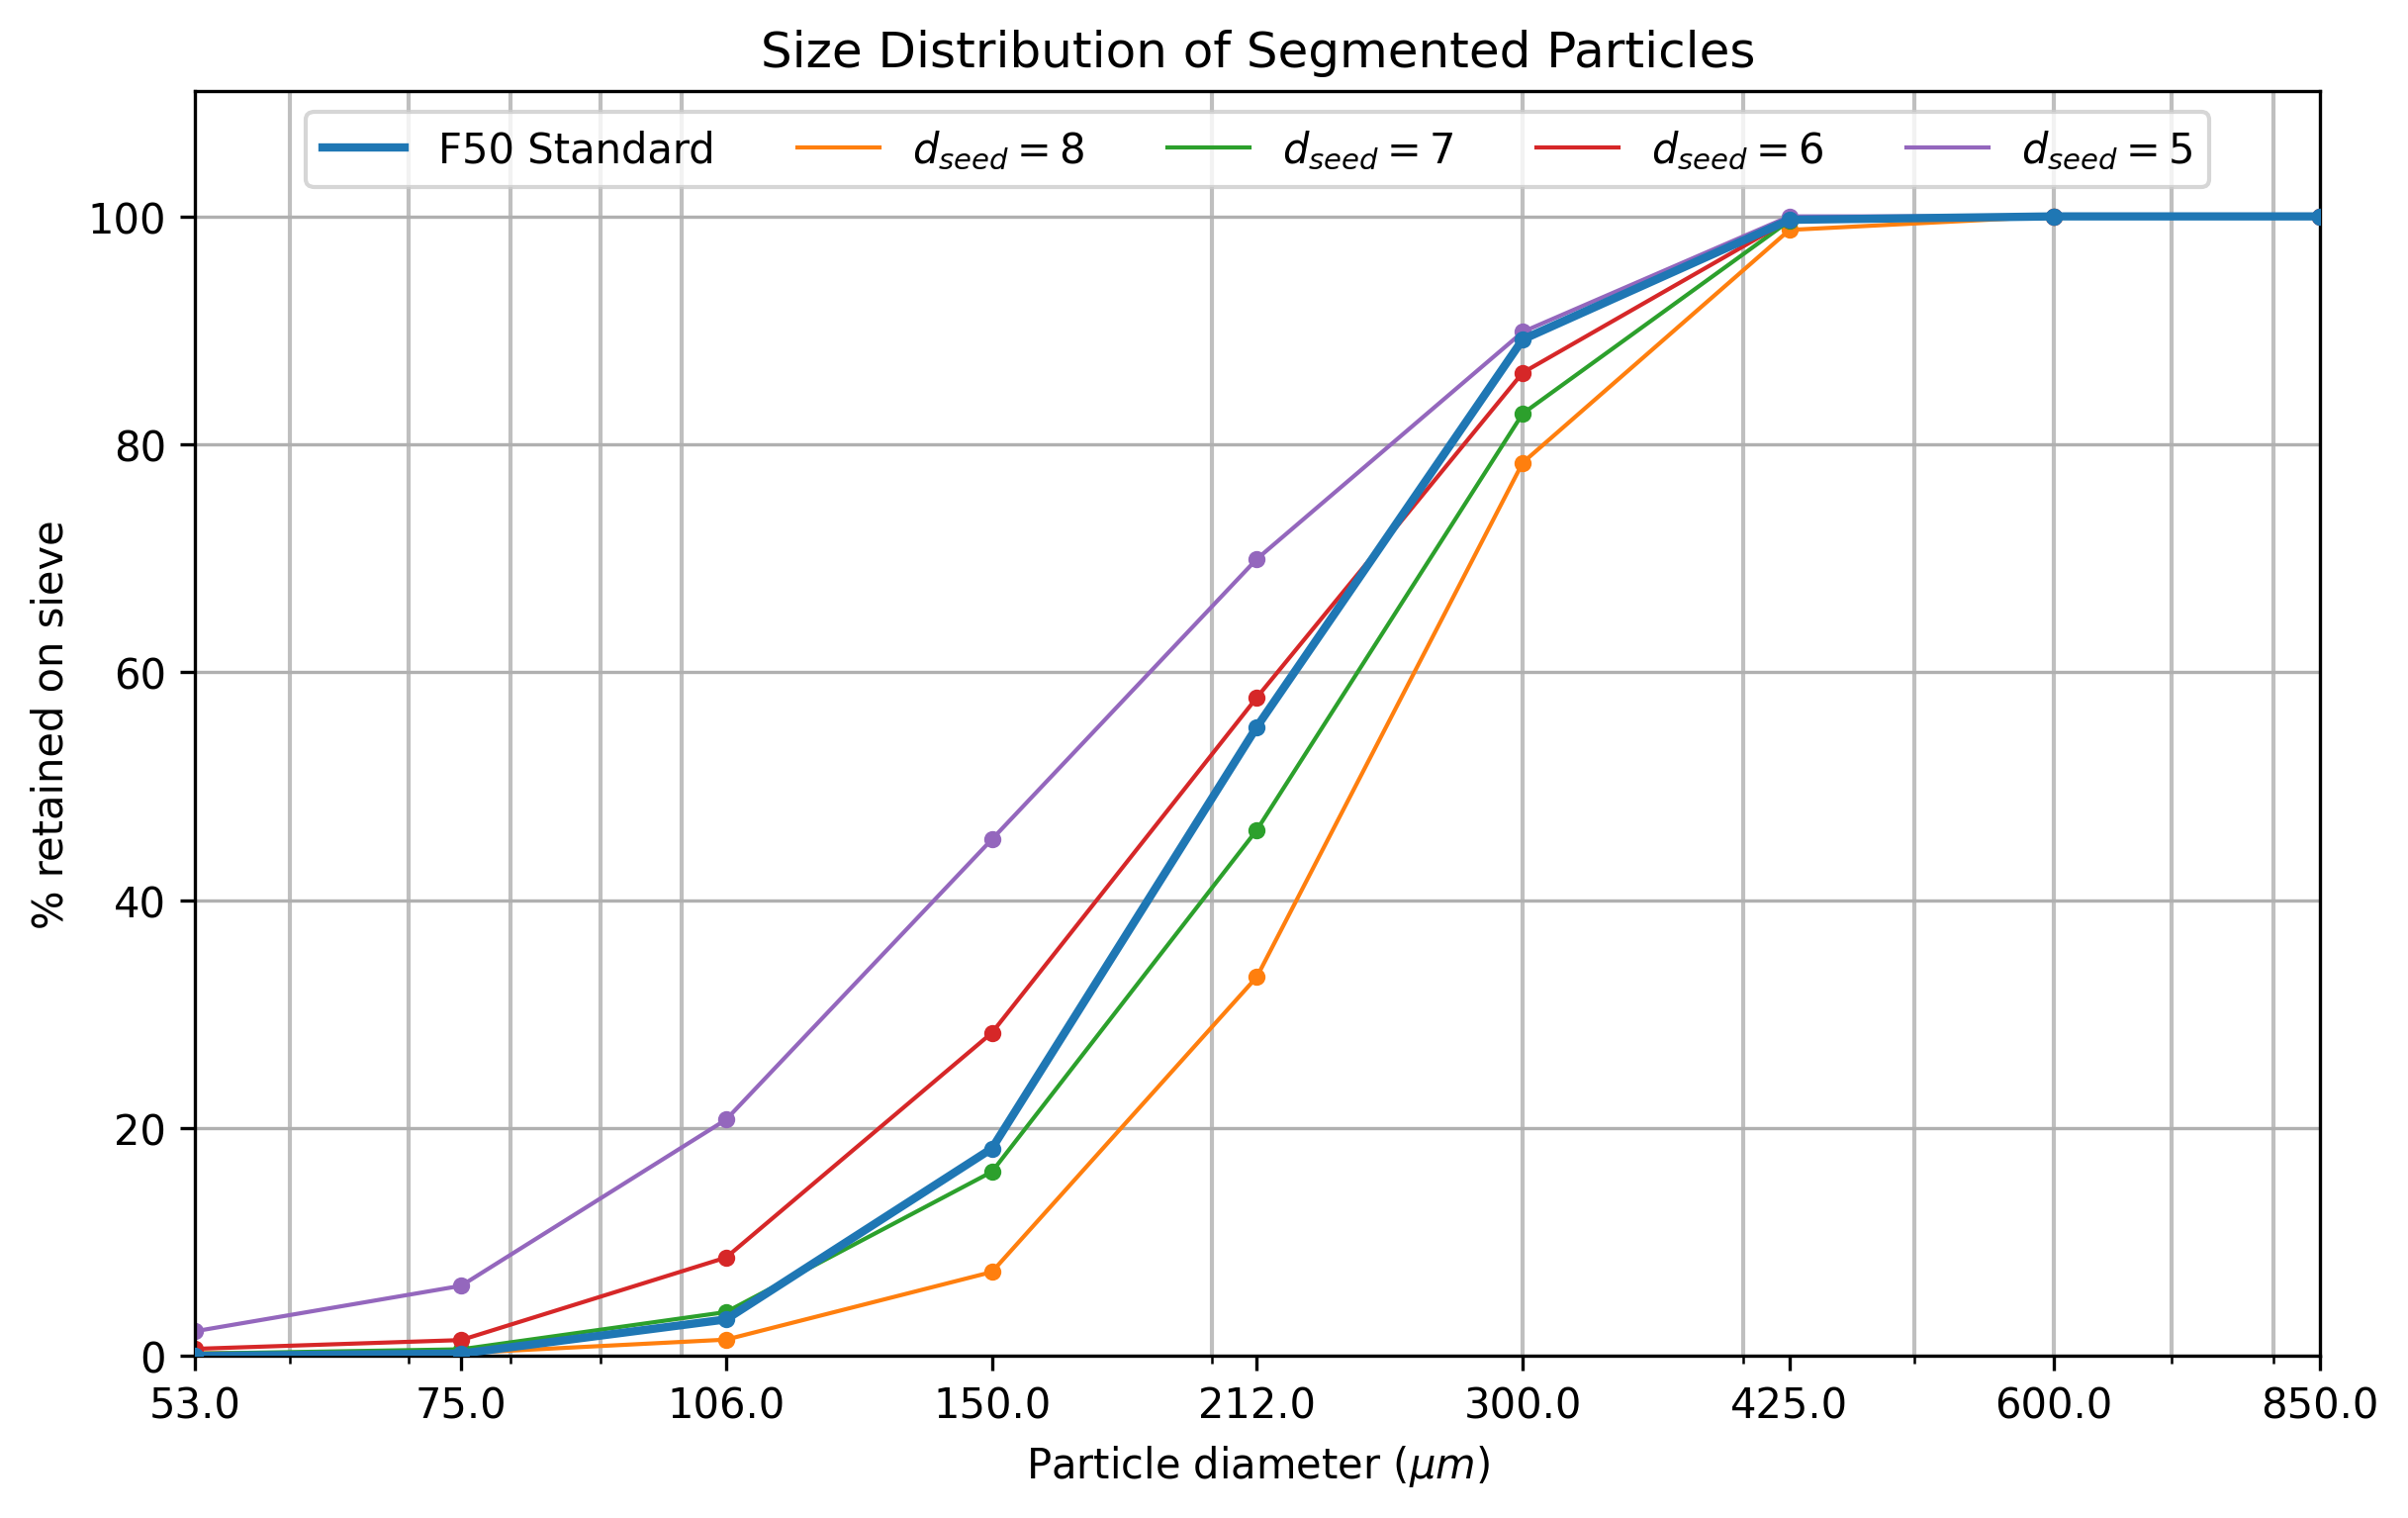

In [200]:
# Plot histogram
fig, ax = plt.subplots(
    figsize=(8, 5), facecolor='white', constrained_layout=True, dpi=300)
x_pos = np.arange(f50_pct.shape[0])  # the label locations
width = 0.5 / min_peak_dist_range.shape[0]  # the width of the bars
ax.scatter(ums_area, np.cumsum(f50_pct), s=10, zorder=3)
ax.plot(
    ums_area, np.cumsum(f50_pct), linewidth=2, zorder=3, label='F50 Standard')
# Plot segmented particle size distributions
for i, dist_i in enumerate(min_peak_dist_range):
    seg_i_pct = sieve_df[f'pct-retained-seg-{dist_i}'].to_numpy()
    seg_i_pct_cum = np.cumsum(seg_i_pct)
    ax.scatter(
        ums_area, np.cumsum(seg_i_pct), s=10, zorder=2)
        # label=f'Segmented,\nseparation = {dist_i}')
    ax.plot(ums_area, np.cumsum(seg_i_pct), linewidth=1, zorder=2,
        label=f'$d_{{seed}}={dist_i}$')
ax.set_title('Size Distribution of Segmented Particles')
ax.set_ylabel(r'% retained on sieve')
ax.set_ylim([0, 111])
ax.set_xlabel('Particle diameter ($\mu m$)')
ax.set_xscale('log')
ax.grid(True, axis='y', zorder=0)
ax.set_xlim([53, 850])
for v in np.concatenate(
    (np.arange(60, 100, 10, dtype=int), np.arange(100, 900, 100, dtype=int))):
    ax.axvline(v, linewidth=1, c='k', alpha=0.25, zorder=0)
ax.set_xticks(ums_area)
ax.set_xticklabels(ums_area)
ax.legend(loc='upper center', ncol=5)
plt.show()

In [159]:
for i in min_peak_dist_range:
    sieve_df[f'pct-retained-diff-{i}'] = np.abs(
        sieve_df['pct-retained'] - sieve_df[f'pct-retained-seg-{i}'])
    print(
        f'Difference between standard and min_peak_distance = {i}:',
        round(sieve_df[f'pct-retained-diff-{i}'].sum(), 2))
sieve_df

Difference between standard and min_peak_distance = 8: 44.37
Difference between standard and min_peak_distance = 7: 19.38
Difference between standard and min_peak_distance = 6: 26.13
Difference between standard and min_peak_distance = 5: 54.26


,usa,um,pct-retained,pct-retained-seg-8,pct-retained-seg-7,pct-retained-seg-6,pct-retained-seg-5,pct-retained-diff-8,pct-retained-diff-7,pct-retained-diff-6,pct-retained-diff-5
8,270,53.0,0.0,0.237530,0.192308,0.616333,2.164009,0.237530,0.192308,0.616333,2.164009
7,200,75.0,0.2,0.000000,0.384615,0.770416,3.986333,0.200000,0.184615,0.570416,3.786333
6,140,106.0,3.0,1.187648,3.269231,7.241911,14.578588,1.812352,0.269231,4.241911,11.578588
5,100,150.0,15.0,5.938242,12.307692,19.722650,24.601367,9.061758,2.692308,4.722650,9.601367
4,70,212.0,37.0,25.890736,30.000000,29.429892,24.601367,11.109264,7.000000,7.570108,12.398633
3,50,300.0,34.0,45.130641,36.538462,28.505393,19.931663,11.130641,2.538462,5.494607,14.068337
2,40,425.0,10.5,20.427553,16.923077,13.405239,10.136674,9.927553,6.423077,2.905239,0.363326
1,30,600.0,0.3,1.187648,0.384615,0.308166,0.000000,0.887648,0.084615,0.008166,0.300000
0,20,850.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


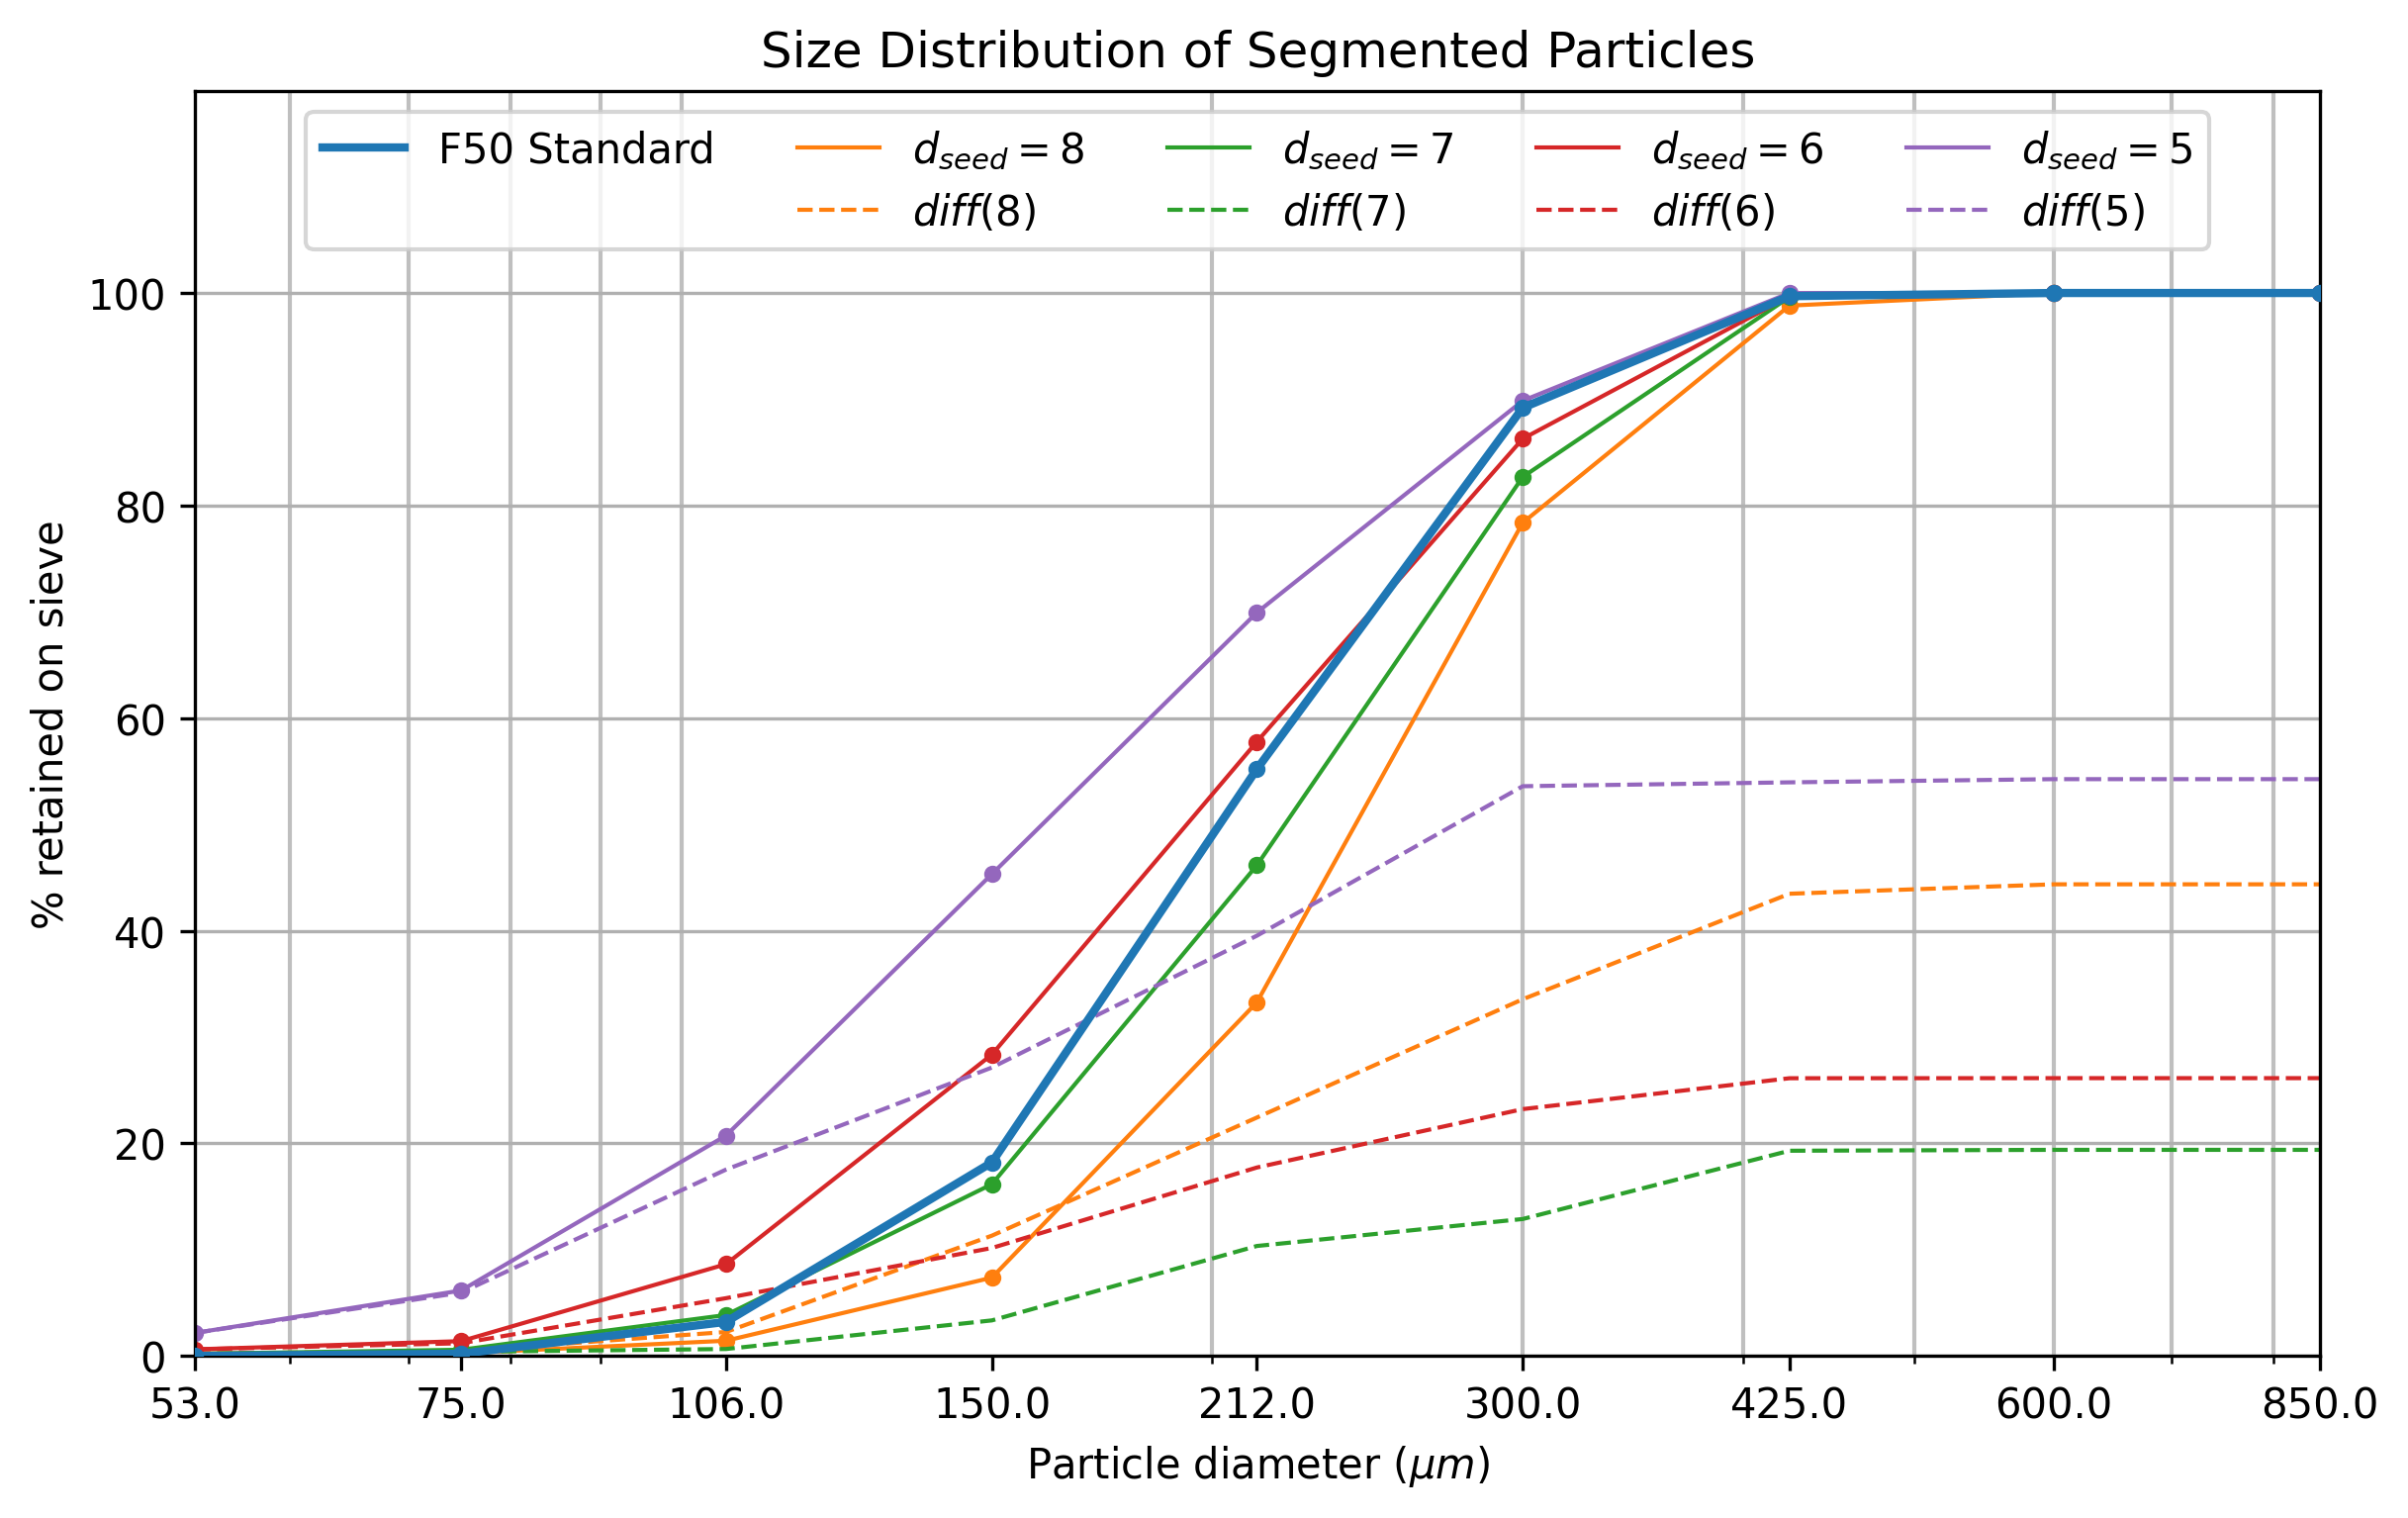

In [201]:
# Plot histogram
fig, ax = plt.subplots(
    figsize=(8, 5), facecolor='white', constrained_layout=True, dpi=300)
x_pos = np.arange(f50_pct.shape[0])  # the label locations
width = 0.5 / min_peak_dist_range.shape[0]  # the width of the bars
ax.scatter(ums_area, np.cumsum(f50_pct), s=10, zorder=3)
ax.plot(
    ums_area, np.cumsum(f50_pct), linewidth=2, zorder=3, label='F50 Standard')
# Invsibile dummy plot to offset labels in legend
ax.plot(np.zeros(0), np.zeros(0), 'w', alpha=0, label=' ')
# Plot segmented particle size distributions
for i, dist_i in enumerate(min_peak_dist_range):
    seg_i_pct = sieve_df[f'pct-retained-seg-{dist_i}'].to_numpy()
    seg_i_pct_cum = np.cumsum(seg_i_pct)
    ax.scatter(
        ums_area, np.cumsum(seg_i_pct), s=10, zorder=2)
        # label=f'Segmented,\nseparation = {dist_i}')
    ax.plot(ums_area, np.cumsum(seg_i_pct), linewidth=1, zorder=2,
        label=f'$d_{{seed}}={dist_i}$')
    # Plot difference between standard and segmented distributions
    seg_i_diff = np.abs(
        sieve_df['pct-retained'] - sieve_df[f'pct-retained-seg-{dist_i}'])
    ax.plot(
        ums_area, np.cumsum(seg_i_diff), '--', linewidth=1, zorder=2,
        c=f'C{i + 1}', label=f'$diff({dist_i})$')
ax.set_title('Size Distribution of Segmented Particles')
ax.set_ylabel(r'% retained on sieve')
ax.set_ylim([0, 119])
ax.set_xlabel('Particle diameter ($\mu m$)')
ax.set_xscale('log')
ax.grid(True, axis='y', zorder=0)
ax.set_xlim([53, 850])
for v in np.concatenate(
    (np.arange(60, 100, 10, dtype=int), np.arange(100, 900, 100, dtype=int))):
    ax.axvline(v, linewidth=1, c='k', alpha=0.25, zorder=0)
ax.set_xticks(ums_area)
ax.set_xticklabels(ums_area)
ax.legend(loc='upper center', ncol=5)
plt.show()